In [1]:
import pandas as pd

# Load and prepare data
df = pd.read_excel('CCS.xlsx', sheet_name='Sheet1')
df.columns = ['sl_no', 'water', 'cement', 'fine_agg', 'coarse_agg', 
              'hearthstone', 'fly_ash', 'super_plasticizer', 'strength']
df = df.drop('sl_no', axis=1)

# Original features only
X = df.drop('strength', axis=1)
y = df['strength']

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select top k features
# Change to 7 to use all features
selector = SelectKBest(score_func=f_regression, k=7)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_columns = X.columns[selector.get_support()]
print("Selected Features:", selected_columns.tolist())

# View F-scores
print("\nFeature Scores:")
for feature, score in zip(X.columns, selector.scores_):
    print(f"{feature}: {score:.4f}")

# Convert to DataFrame with column names
X_selected_df = pd.DataFrame(X_selected, columns=selected_columns)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)


Selected Features: ['water', 'cement', 'fine_agg', 'coarse_agg', 'hearthstone', 'fly_ash', 'super_plasticizer']

Feature Scores:
water: 27.8202
cement: 126.8365
fine_agg: 27.2284
coarse_agg: 4.7036
hearthstone: 72.4669
fly_ash: 17.4421
super_plasticizer: 112.1723


In [3]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost with optimized parameters
xgb_params = {
    'n_estimators': [320, 330, 350], # 320, 330, 350
    'learning_rate': [0.01, 0.02, 0.03],  # 0.01, 0.02, 0.03
    'max_depth': [4, 5],
    'min_child_weight': [2, 3],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.2, 0.3],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [1.5, 2.0]
}
xgb_grid = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    xgb_params,
    n_iter=10, # 10
    cv=kfold,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print(f"\nRunning RandomizedSearchCV for XGBoost...")
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
print(f"\nXGBoost Best Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Best CV R²: {xgb_grid.best_score_:.4f}")

# Gradient Boosting with optimized parameters
gb_params = {
            'n_estimators': [300, 350, 400],      # Increased from 400
            'learning_rate': [0.05, 0.07],   # Reduced from 0.1
            'max_depth': [2, 3],             # Reduced from 7
            'subsample': [0.5, 0.6],         # Reduced from 1.0
            'min_samples_split': [10, 15],   # New constraint
            'min_samples_leaf': [3, 4]       # New constraint
}
gb_grid = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    n_iter=20,
    cv=5, # 5
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print(f"\nRunning RandomizedSearchCV for Gradient Boosting...")
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_
print(f"\nGradient Boosting Best Parameters: {gb_grid.best_params_}")
print(f"Gradient Boosting Best CV R²: {gb_grid.best_score_:.4f}")

# Random Forest with optimized parameters
rf_params = {
    'n_estimators': [300, 350, 400],
    'max_depth': [None, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 3],
    'max_features': [0.4, 0.5]
}
rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
print(f"\nRunning RandomizedSearchCV for Random Forest...")
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print(f"\nRandom Forest Best Parameters: {rf_grid.best_params_}")
print(f"Random Forest Best CV R²: {rf_grid.best_score_:.4f}")

# Evaluate all models
best_models = {
    'XGBoost': xgb_best,
    'Gradient Boosting': gb_best,
    'Random Forest': rf_best
}


Running RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

XGBoost Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 1.0, 'n_estimators': 350, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.9}
XGBoost Best CV R²: 0.7600

Running RandomizedSearchCV for Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Gradient Boosting Best Parameters: {'subsample': 0.6, 'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.07}
Gradient Boosting Best CV R²: 0.7971

Running RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Random Forest Best Parameters: {'n_estimators': 350, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 15}
Random Forest Best CV R²: 0.7100


In [4]:
# Train and evaluate
results = {}
for name, model in best_models.items():
    print(f"\nEvaluating {name} on test set...")
    ### model.fit(X_train, y_train)
    
    # Generate predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    gap = train_r2 - test_r2  # Generalization gap calculation
    
    # Store results
    results[name] = {
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Generalization Gap': gap
    }
# Results comparison
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df.sort_values('Test R2', ascending=False)[['Train R2','Test R2', 'Train RMSE',  'Test RMSE', 'Generalization Gap']])


Evaluating XGBoost on test set...

Evaluating Gradient Boosting on test set...

Evaluating Random Forest on test set...

Model Performance Comparison:
                   Train R2   Test R2  Train RMSE  Test RMSE  \
XGBoost            0.977220  0.871578    2.252742   6.008205   
Gradient Boosting  0.974306  0.870663    2.392481   6.029572   
Random Forest      0.923254  0.791412    4.134869   7.657199   

                   Generalization Gap  
XGBoost                      0.105642  
Gradient Boosting            0.103643  
Random Forest                0.131842  



Best Performing Model: XGBoost


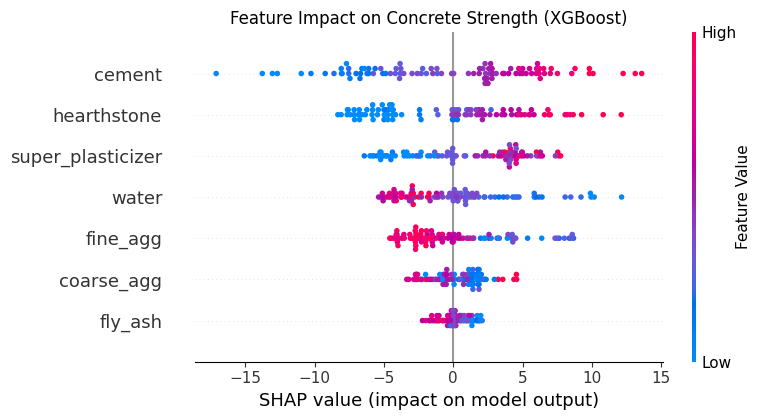

In [5]:
import shap
import matplotlib.pyplot as plt

# SHAP analysis
best_model_name = max(results, key=lambda x: results[x]['Test R2'])
best_model = best_models[best_model_name]

print(f"\nBest Performing Model: {best_model_name}")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

plt.figure(figsize=(10,5))
shap.plots.beeswarm(shap_values, show=False)
plt.title(f'Feature Impact on Concrete Strength ({best_model_name})')
plt.gcf().axes[-1].set_ylabel('Feature Value', size=11)
plt.tight_layout()
plt.show()

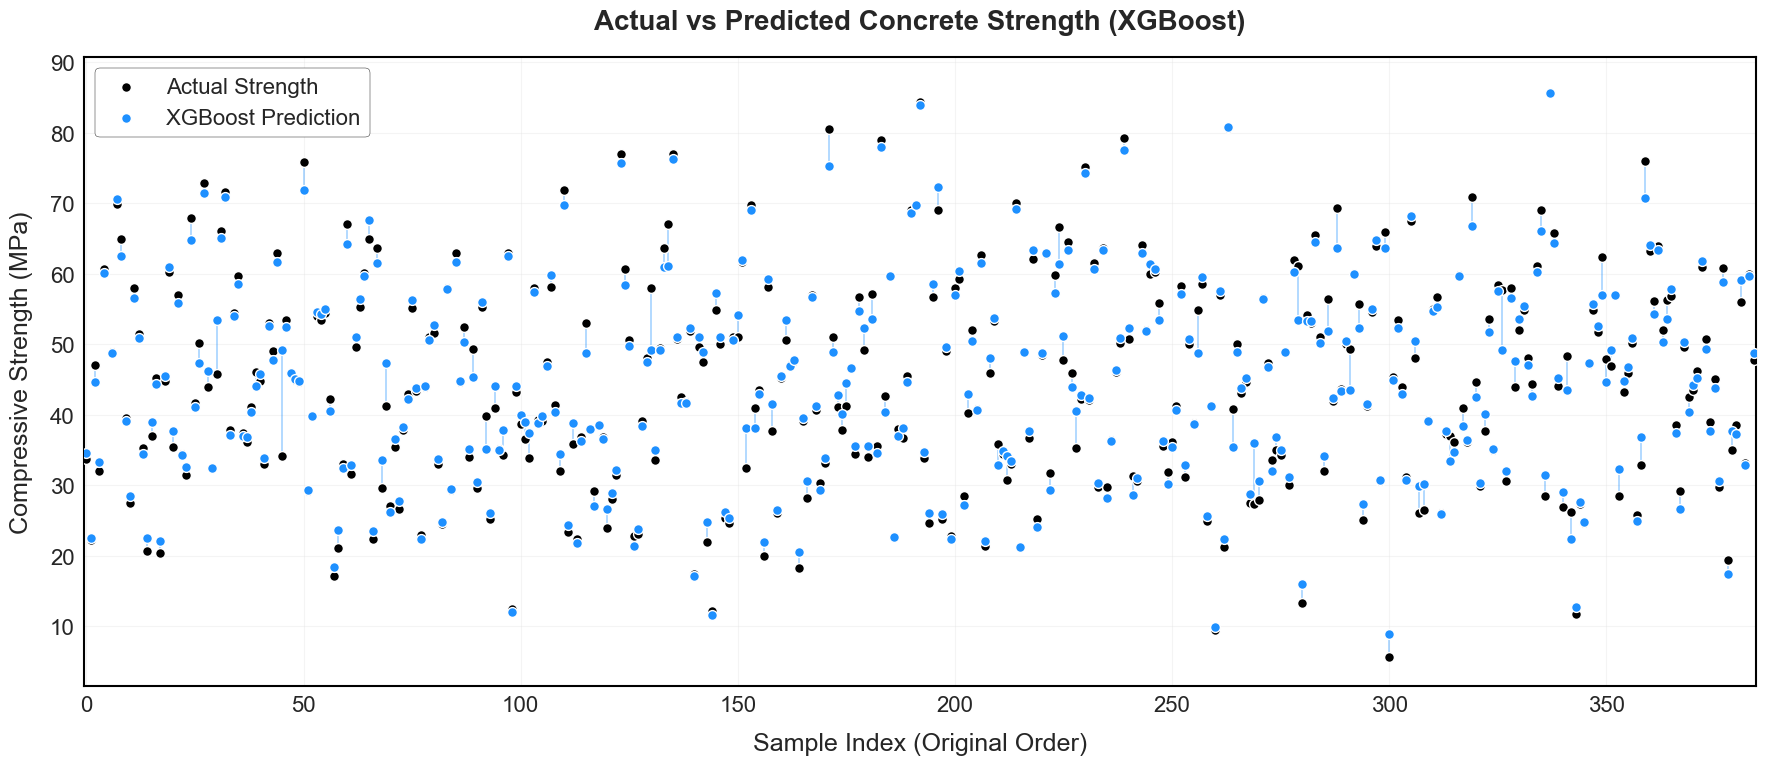

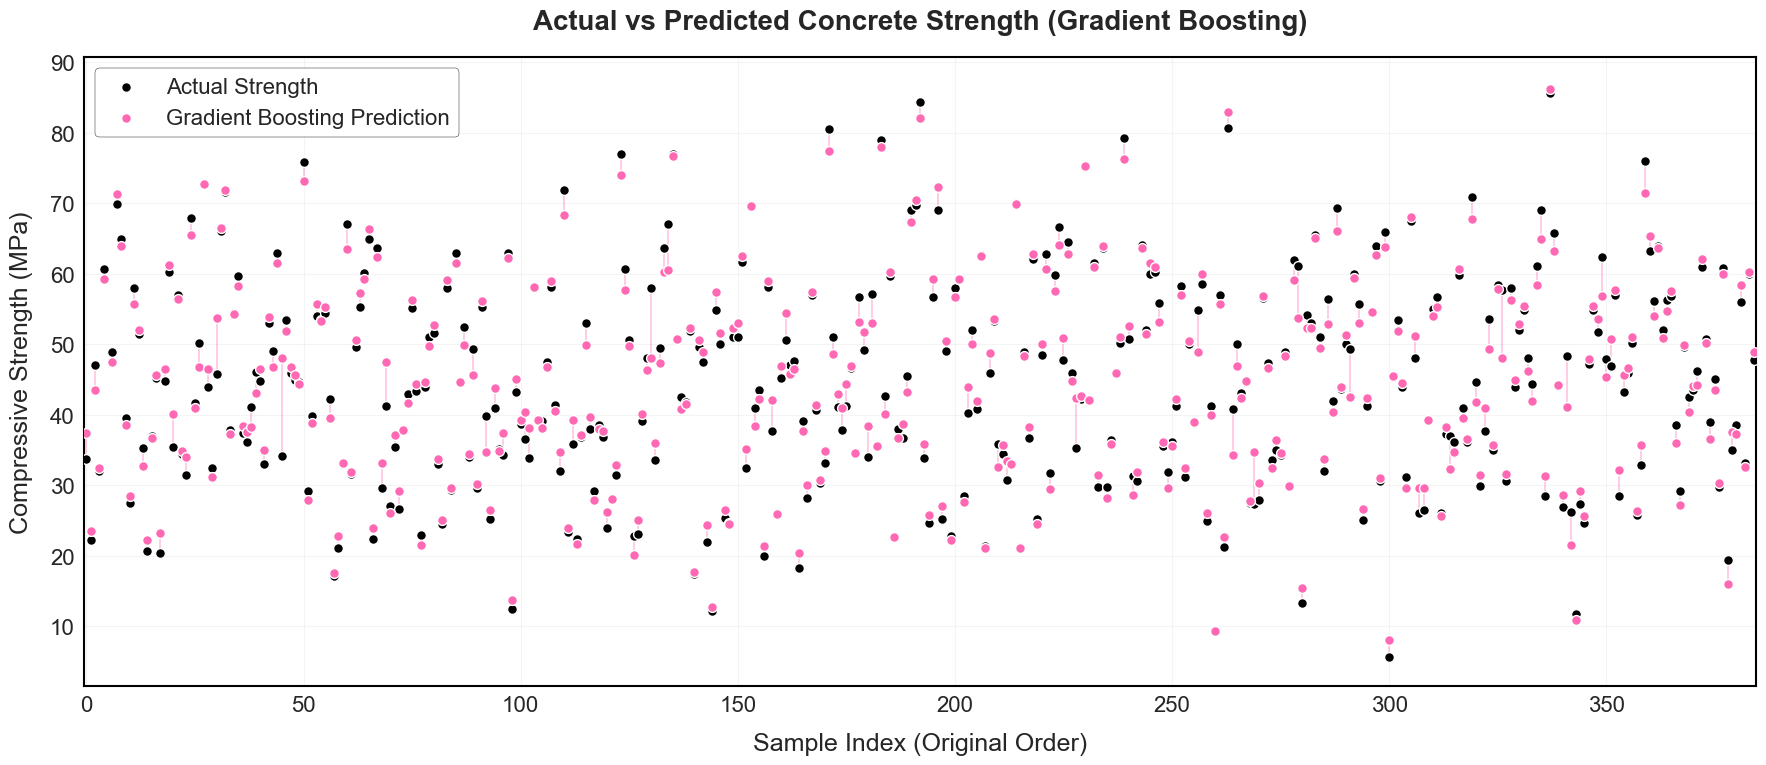

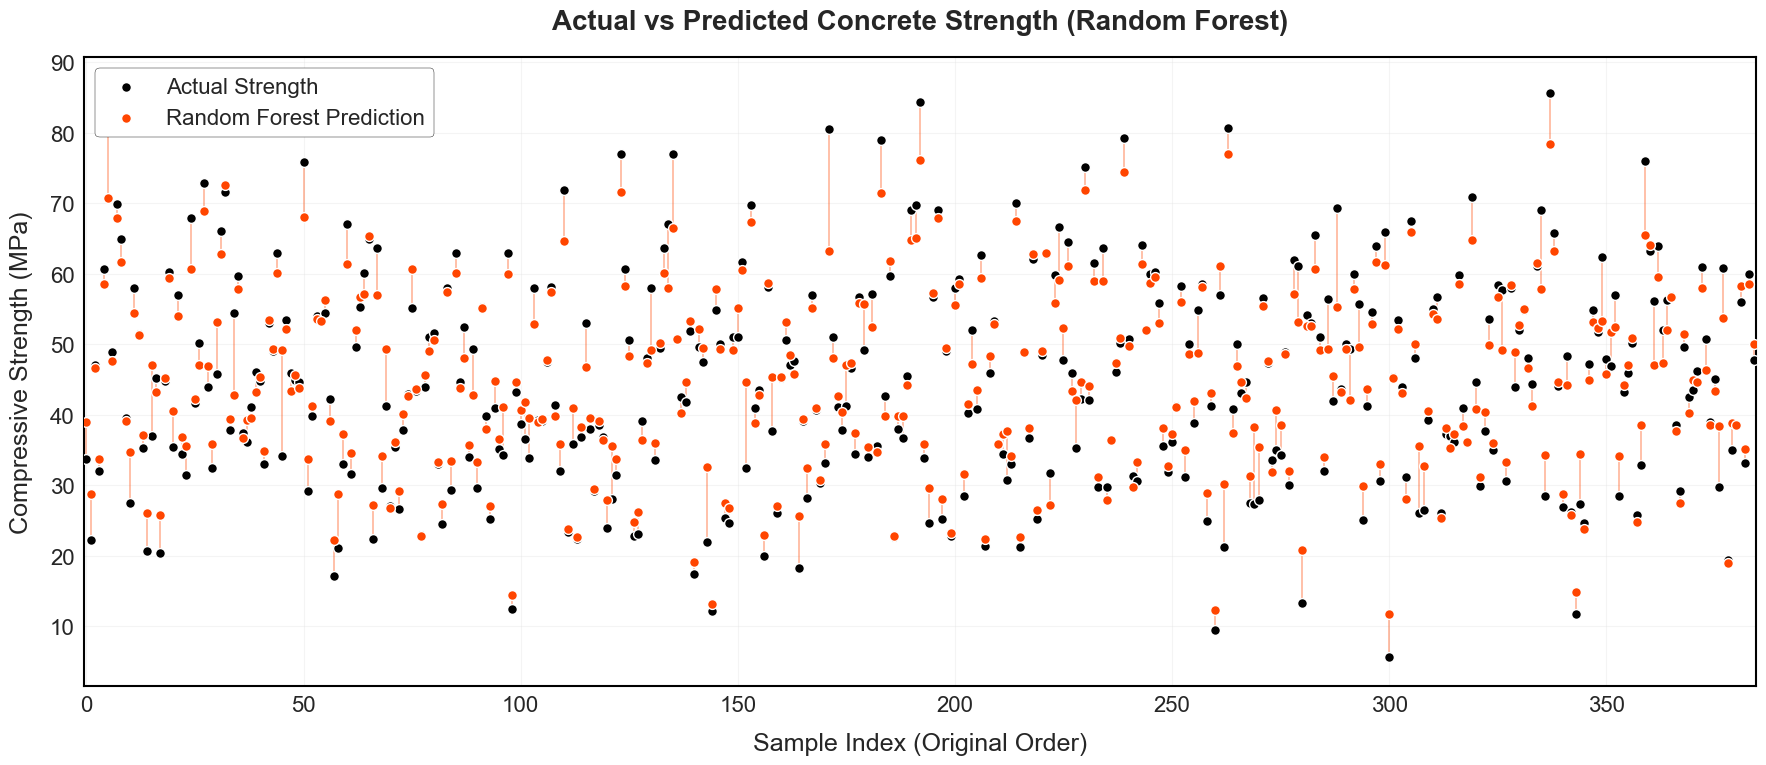

In [9]:
# Configure plot style
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5,
    'figure.facecolor': 'white'
})

# Define model styles with pink, red, blue colors (all circles)
model_config = {
    'Gradient Boosting': {'color': '#FF69B4', 'marker': 'o'},  # Pink
    'Random Forest': {'color': '#FF4500', 'marker': 'o'},      # Red
    'XGBoost': {'color': '#1E90FF', 'marker': 'o'}             # Blue
}

# Create one plot per model
plotted_models = set()
for model_name, model in best_models.items():
    # Match model names
    display_name = next((k for k in model_config.keys() if k.lower() in model_name.lower()), None)
    if not display_name or display_name in plotted_models:
        continue
    plotted_models.add(display_name)
    
    style = model_config[display_name]
    y_pred = model.predict(X_train)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Light grid only (no major/minor distinction)
    ax.grid(True, color='#DDDDDD', linestyle='-', linewidth=0.8, alpha=0.3)
    
    # Error lines
    ax.vlines(x=np.arange(len(y_train)),
              ymin=np.minimum(y_train, y_pred),
              ymax=np.maximum(y_train, y_pred),
              colors=style['color'],
              linewidths=1.2,
              alpha=0.4)
    
    # Actual values (black circles)
    ax.scatter(np.arange(len(y_train)), y_train,
               color='#000000',
               marker='o',
               s=50,
               edgecolor='white',
               linewidth=1,
               label='Actual Strength',
               zorder=3)
    
    # Predicted values (colored circles)
    ax.scatter(np.arange(len(y_train)), y_pred,
               color=style['color'],
               marker='o',
               s=50,
               edgecolor='white',
               linewidth=1,
               label=f'{display_name} Prediction',
               zorder=3)
    
    # Formatting
    ax.set_title(f'Actual vs Predicted Concrete Strength ({display_name})', 
                 pad=20, fontweight='bold')
    ax.set_xlabel('Sample Index (Original Order)', labelpad=12)
    ax.set_ylabel('Compressive Strength (MPa)', labelpad=12)
    ax.set_xlim(-0.5, len(y_train)-0.5)
    
    # Legend in box (upper left)
    legend = ax.legend(loc='upper left',
                      frameon=True,
                      framealpha=1,
                      edgecolor='black',
                      facecolor='white')
    
    plt.tight_layout()
    plt.savefig(f'Strength_Comparison_{display_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

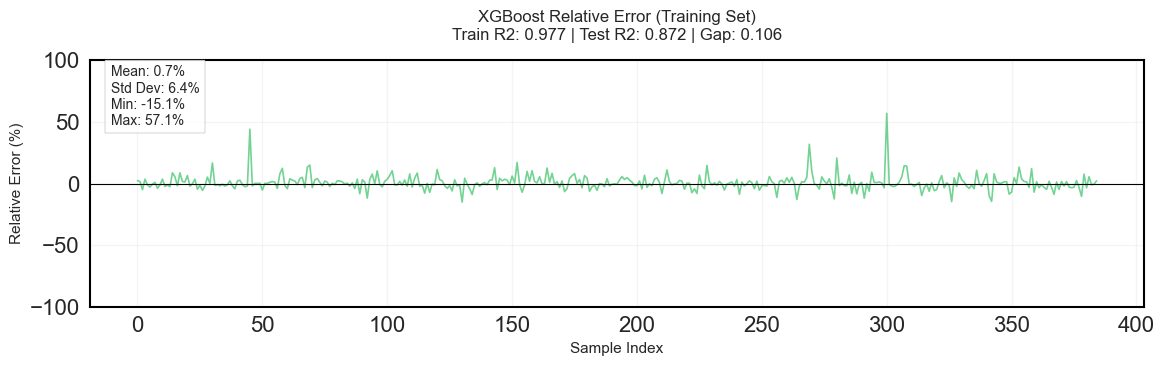

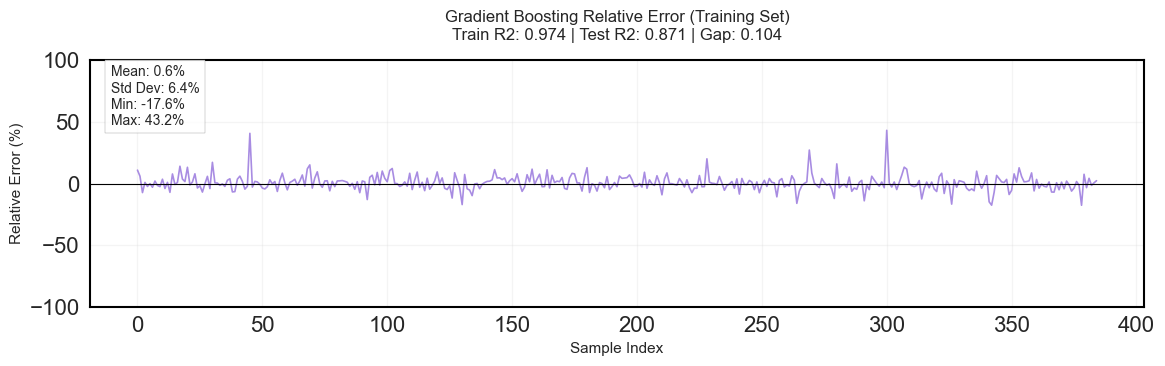

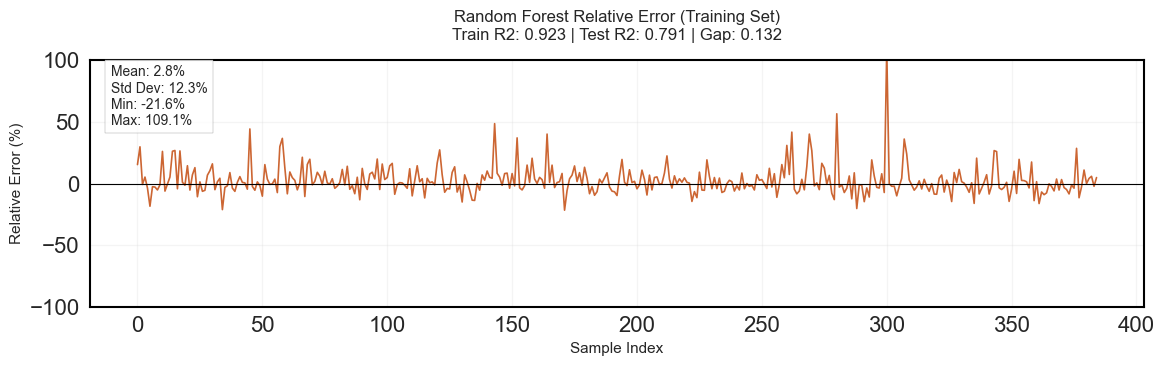

All individual model error plots saved successfully!


In [11]:
# Define model styles
model_styles = {
    'Random Forest': {'color': '#C04000', 'linestyle': '-', 'linewidth': 1.2},  # Brown/red
    'Gradient Boosting': {'color': '#9370DB', 'linestyle': '-', 'linewidth': 1.2},  # Purple
    'XGBoost': {'color': '#50C878', 'linestyle': '-', 'linewidth': 1.2}  # Green
}

# Create individual plots for each model
for name, model in best_models.items():
    if name not in model_styles:
        continue
    
    # Create landscape figure
    plt.figure(figsize=(12, 4))
    
    # Calculate relative errors
    train_pred = model.predict(X_train)
    relative_error = ((train_pred - y_train) / y_train) * 100
    
    # Plot zig-zag line
    plt.plot(np.arange(len(y_train)), relative_error,
             **model_styles[name],
             alpha=0.8)
    
    # Formatting
    plt.ylim(-100, 100)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.title(f'{name} Relative Error (Training Set)\n'
              f'Train R2: {results[name]["Train R2"]:.3f} | '
              f'Test R2: {results[name]["Test R2"]:.3f} | '
              f'Gap: {results[name]["Train R2"] - results[name]["Test R2"]:.3f}',
              fontsize=12, pad=15)
    plt.xlabel('Sample Index', fontsize=11)
    plt.ylabel('Relative Error (%)', fontsize=11)
    plt.grid(True, alpha=0.2)
    
    # Add error statistics box
    stats_text = (f'Mean: {np.mean(relative_error):.1f}%\n'
                  f'Std Dev: {np.std(relative_error):.1f}%\n'
                  f'Min: {np.min(relative_error):.1f}%\n'
                  f'Max: {np.max(relative_error):.1f}%')
    
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.savefig(f'{name}_relative_error.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory

print("All individual model error plots saved successfully!")

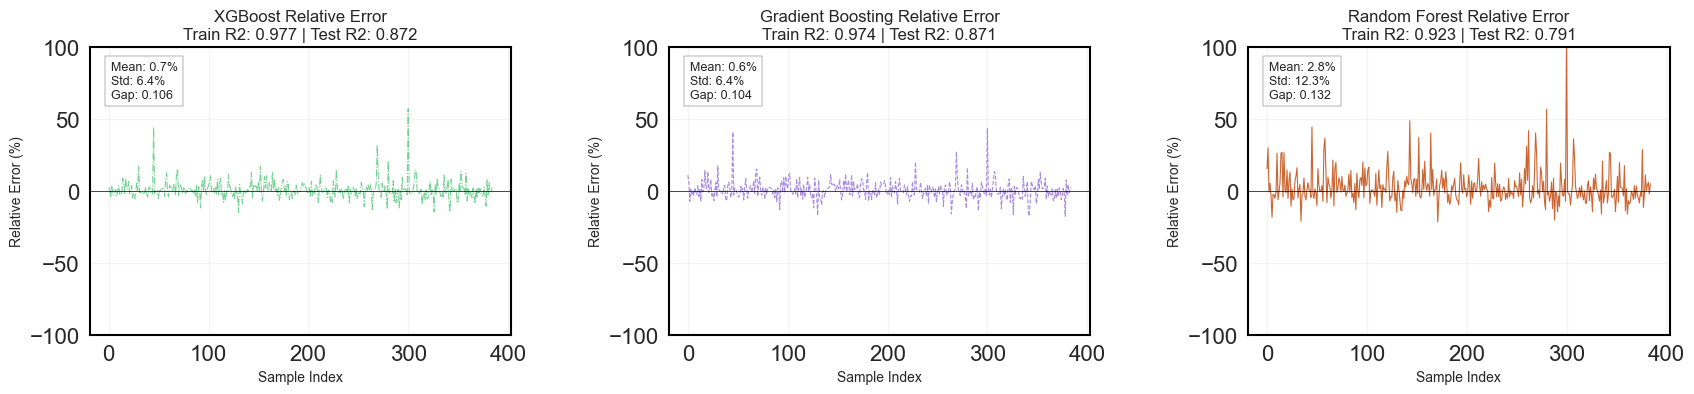

In [12]:
# Define model colors and line styles
model_styles = {
    'Random Forest': {'color': '#C04000', 'linestyle': '-', 'linewidth': 0.8},  # Brown/red
    'Gradient Boosting': {'color': '#9370DB', 'linestyle': '--', 'linewidth': 0.8},  # Purple
    'XGBoost': {'color': '#50C878', 'linestyle': '-.', 'linewidth': 0.8}  # Green
}

plt.figure(figsize=(18, 5))

# Calculate and plot relative errors for each model
for i, (name, model) in enumerate(best_models.items(), 1):
    if name not in model_styles:
        continue
        
    # Get predictions
    train_pred = model.predict(X_train)
    relative_error = ((train_pred - y_train) / y_train) * 100
    
    # Create subplot
    plt.subplot(1, 3, i)
    
    # Plot zig-zag line
    plt.plot(np.arange(len(y_train)), relative_error,
             **model_styles[name],
             alpha=0.8,
             label=name)
    
    # Formatting
    plt.ylim(-100, 100)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.title(f'{name} Relative Error\nTrain R2: {results[name]["Train R2"]:.3f} | Test R2: {results[name]["Test R2"]:.3f}',
              fontsize=12)
    plt.xlabel('Sample Index', fontsize=10)
    plt.ylabel('Relative Error (%)', fontsize=10)
    plt.grid(True, alpha=0.2)
    
    # Add error statistics
    stats_text = (f'Mean: {np.mean(relative_error):.1f}%\n'
                  f'Std: {np.std(relative_error):.1f}%\n'
                  f'Gap: {results[name]["Train R2"] - results[name]["Test R2"]:.3f}')
    
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes,
             fontsize=9,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout(pad=2.5)
plt.savefig('model_relative_errors_lines.png', dpi=300, bbox_inches='tight')
plt.show()

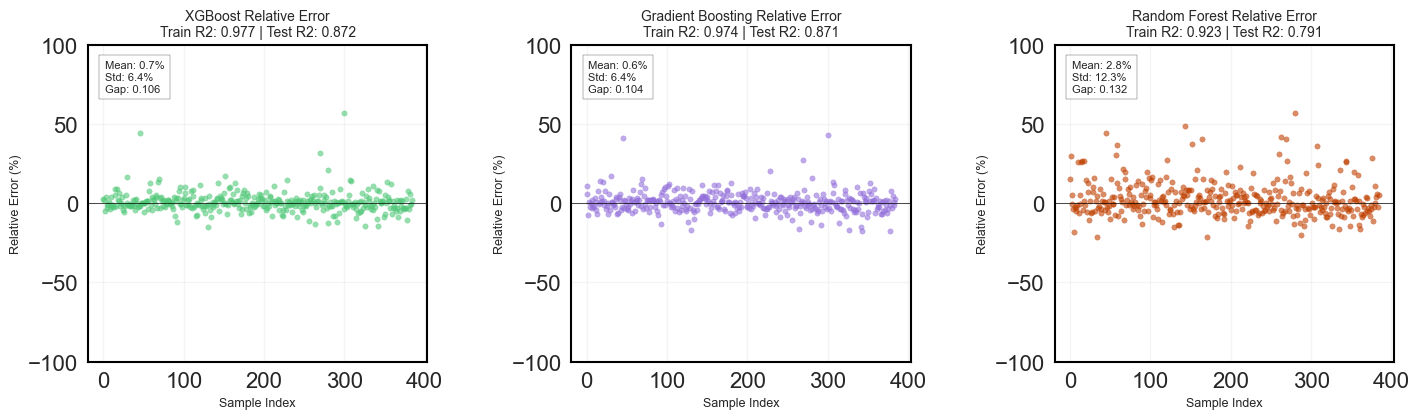

In [13]:
# Define model colors (matching your reference)
model_colors = {
    'Random Forest': '#C04000',  # Brown/red
    'Gradient Boosting': '#9370DB',  # Purple
    'XGBoost': '#50C878'  # Green
}

plt.figure(figsize=(15, 5))

# Calculate and plot relative errors for each model
for i, (name, model) in enumerate(best_models.items(), 1):
    if name not in model_colors:
        continue
        
    # Get predictions (using your existing code structure)
    train_pred = model.predict(X_train)
    relative_error = ((train_pred - y_train) / y_train) * 100
    
    # Create subplot
    plt.subplot(1, 3, i)
    plt.scatter(np.arange(len(y_train)), relative_error, 
                color=model_colors[name],
                alpha=0.6,
                s=15)
    
    # Formatting (matching your specifications)
    plt.ylim(-100, 100)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.title(f'{name} Relative Error\nTrain R2: {results[name]["Train R2"]:.3f} | Test R2: {results[name]["Test R2"]:.3f}',
              fontsize=10)
    plt.xlabel('Sample Index', fontsize=9)
    plt.ylabel('Relative Error (%)', fontsize=9)
    plt.grid(True, alpha=0.2)
    
    # Add error statistics (using your metrics)
    plt.text(0.05, 0.95,
             f'Mean: {np.mean(relative_error):.1f}%\n'
             f'Std: {np.std(relative_error):.1f}%\n'
             f'Gap: {results[name]["Train R2"] - results[name]["Test R2"]:.3f}',
             transform=plt.gca().transAxes,
             fontsize=8,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout(pad=2.0)
plt.savefig('model_relative_errors.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 800x500 with 0 Axes>

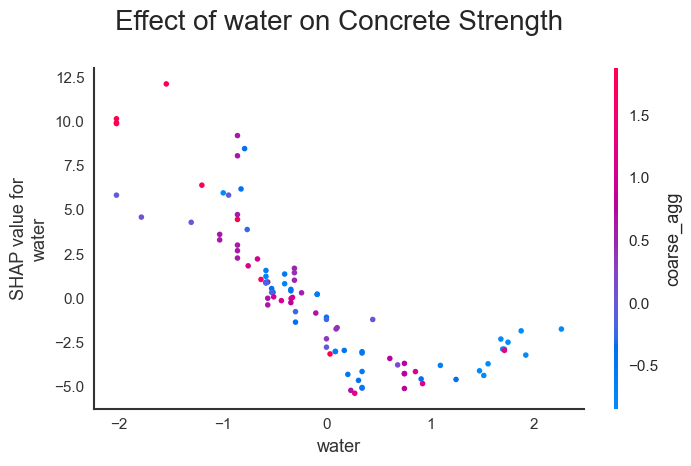

<Figure size 800x500 with 0 Axes>

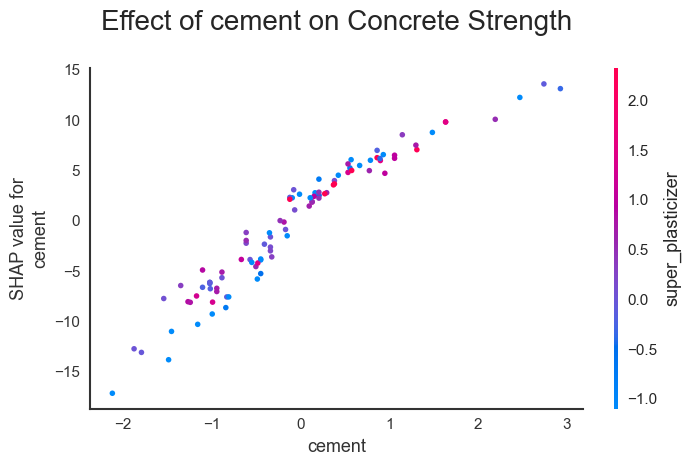

<Figure size 800x500 with 0 Axes>

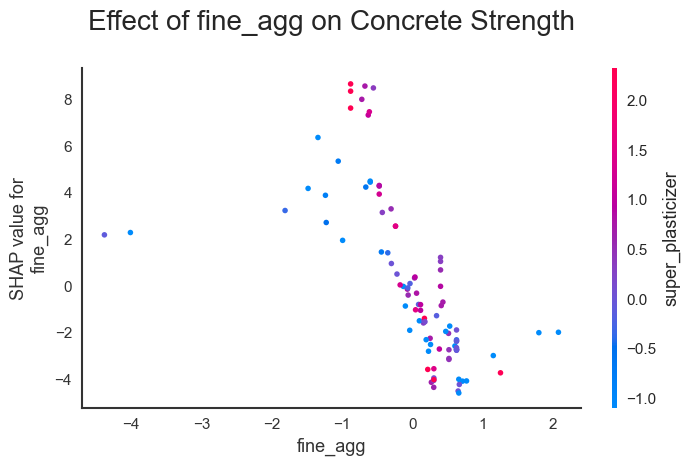

<Figure size 800x500 with 0 Axes>

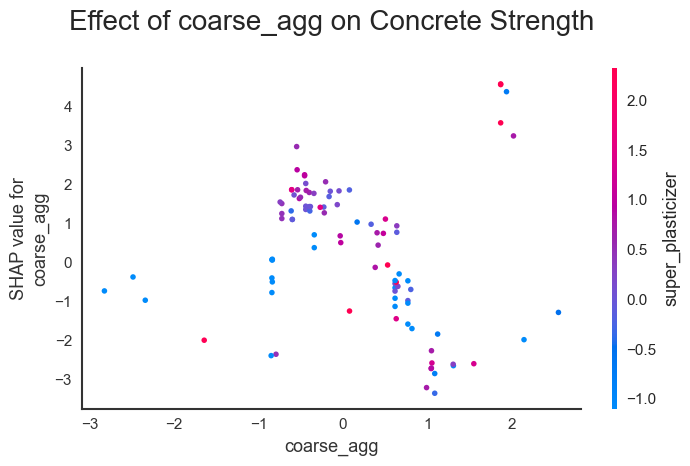

<Figure size 800x500 with 0 Axes>

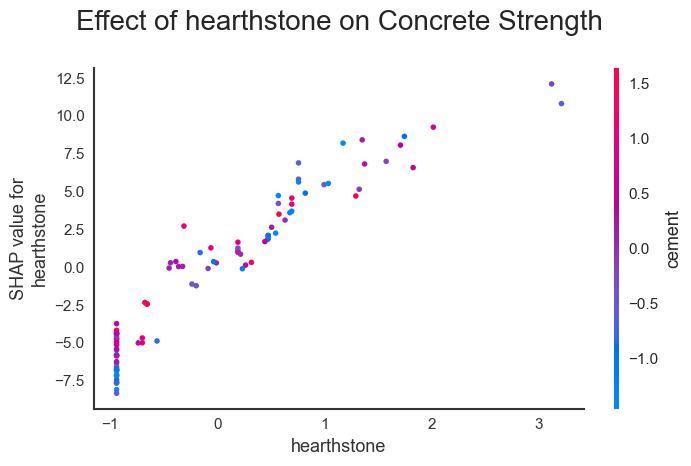

<Figure size 800x500 with 0 Axes>

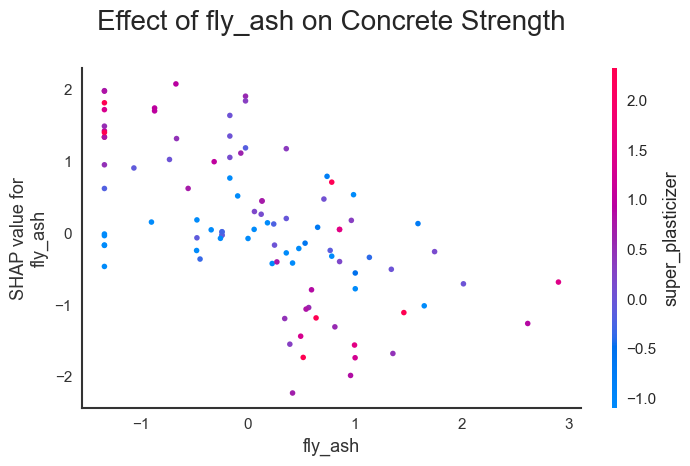

<Figure size 800x500 with 0 Axes>

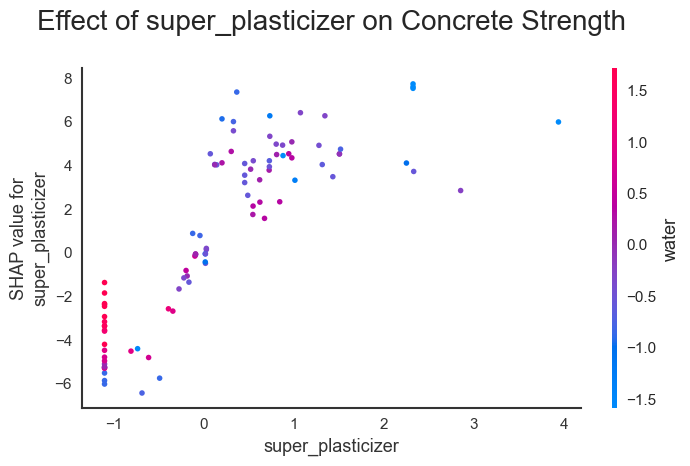

<Figure size 900x500 with 0 Axes>

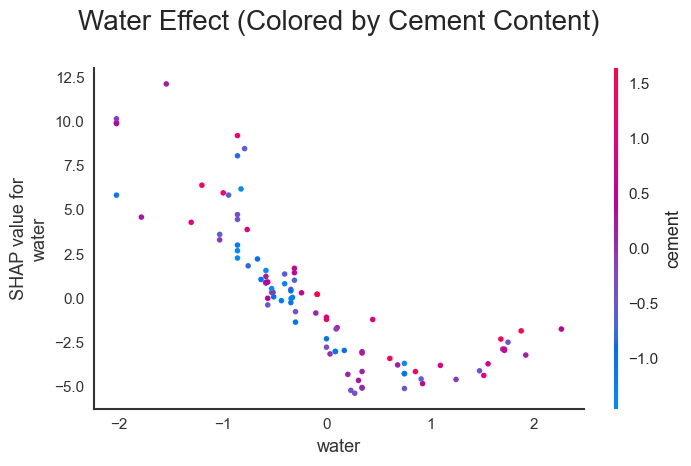

In [16]:
# 1. Get SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# 2. Features to analyze
features = ['water', 'cement', 'fine_agg', 'coarse_agg', 'hearthstone', 'fly_ash', 'super_plasticizer']

# 3. Create and save plots
for feature in features:
    plt.figure(figsize=(8, 5))
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        show=False
    )
    plt.title(f"Effect of {feature} on Concrete Strength\n")
    plt.tight_layout()
    
    # Save and show
    plt.savefig(f'{feature}_impact.png', dpi=120, bbox_inches='tight')
    plt.show()
    plt.close()

# 4. Special water-cement interaction plot
if all(f in X_test.columns for f in ['water', 'cement']):
    plt.figure(figsize=(9, 5))
    shap.dependence_plot(
        'water',
        shap_values,
        X_test,
        interaction_index='cement',
        show=False
    )
    plt.title("Water Effect (Colored by Cement Content)\n")
    plt.tight_layout()
    
    # Save and show
    plt.savefig('water_cement_interaction.png', dpi=120, bbox_inches='tight')
    plt.show()
    plt.close()

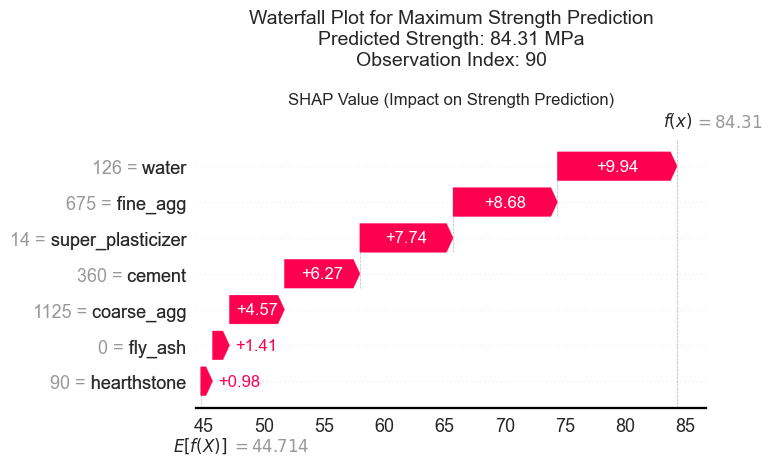


Feature Values for Maximum Strength Prediction:


,322
water,126.00
cement,360.00
fine_agg,675.00
coarse_agg,1125.00
hearthstone,90.00
fly_ash,0.00
super_plasticizer,14.00


In [17]:
# 1. Prepare SHAP data
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# 2. Find observation with maximum predicted strength
max_idx = np.argmax(best_model.predict(X_test))
max_prediction = best_model.predict(X_test.iloc[max_idx:max_idx+1])[0]

# 3. Get original feature values (inverse transform)
X_test_unscaled = pd.DataFrame(
    scaler.inverse_transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# 4. Create waterfall plot
plt.figure(figsize=(12, 6))
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[max_idx],
        base_values=explainer.expected_value,
        data=X_test_unscaled.iloc[max_idx],  # Original units
        feature_names=X_test.columns.tolist()
    ),
    max_display=12,  # Show all features
    show=False
)

# 5. Format plot
plt.title(
    f'Waterfall Plot for Maximum Strength Prediction\n'
    f'Predicted Strength: {max_prediction:.2f} MPa\n'
    f'Observation Index: {max_idx}',
    pad=20,
    fontsize=14
)
plt.xlabel('SHAP Value (Impact on Strength Prediction)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.2, linestyle='--')

# 6. Highlight critical features
ax = plt.gca()
for idx, feature in enumerate(X_test.columns):
    if abs(shap_values[max_idx][idx]) > 0.5:  # Threshold for importance
        ax.get_yticklabels()[idx].set_color('red')  # Highlight in red

plt.tight_layout()

# 7. Save and show
plt.savefig('max_strength_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Display feature values
print("\nFeature Values for Maximum Strength Prediction:")
display(X_test_unscaled.iloc[max_idx].to_frame().style.format("{:.2f}").background_gradient(cmap='Blues'))

In [18]:
from IPython.display import display, HTML

# 1. Load your model and explainer (assuming they're already trained)
explainer = shap.TreeExplainer(best_model)

# 2. Define target strength and find optimal observation
target_strength = 50  # Adjust based on your requirements
optimal_idx = np.argmin(np.abs(best_model.predict(X_test) - target_strength))

# 3. Get SHAP values for the optimal observation
shap_values = explainer.shap_values(X_test.iloc[optimal_idx:optimal_idx+1])[0]
prediction = best_model.predict(X_test.iloc[optimal_idx:optimal_idx+1])[0]

# 4. Inverse-transform scaled features to original values
X_test_unscaled = pd.DataFrame(
    scaler.inverse_transform(X_test),  # Critical: Inverse scaling
    columns=X_test.columns,
    index=X_test.index
)

# 5. Generate force plot with original values
shap.initjs()
force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=X_test_unscaled.iloc[optimal_idx],  # Use unscaled data
    feature_names=X_test.columns.tolist(),
    text_rotation=15,
    matplotlib=False
)

# 6. Save and display
shap.save_html("optimal_force_plot_original_units.html", force_plot)
display(HTML("optimal_force_plot_original_units.html"))

# 7. Print key info
print(f"Optimal Observation Index: {optimal_idx}")
print(f"Target Strength: {target_strength} MPa | Predicted: {prediction:.2f} MPa")
print("\nFeature Values (Original Units):")
print(X_test_unscaled.iloc[optimal_idx])

Optimal Observation Index: 7
Target Strength: 50 MPa | Predicted: 49.83 MPa

Feature Values (Original Units):
water                178.00
cement               333.80
fine_agg             859.70
coarse_agg           931.30
hearthstone           95.70
fly_ash              126.80
super_plasticizer     16.16
Name: 418, dtype: float64


In [19]:
from IPython.display import display, HTML

# 1. Load best model
best_model_name = max(results, key=lambda x: results[x]['Test R2'])
best_model = best_models[best_model_name]
explainer = shap.TreeExplainer(best_model)

# 2. Define "optimal" (e.g., target strength = 50 MPa)
target_strength = 50  # Adjust based on your requirements
optimal_idx = np.argmin(np.abs(best_model.predict(X_test) - target_strength))

# 3. Get SHAP values and prediction
shap_values = explainer.shap_values(X_test.iloc[optimal_idx:optimal_idx+1])[0]
prediction = best_model.predict(X_test.iloc[optimal_idx:optimal_idx+1])[0]

# 4. Generate force plot with original values
shap.initjs()
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values,
    X_test.iloc[optimal_idx],
    feature_names=X_test.columns.tolist(),
    text_rotation=15,
    matplotlib=False
)

# 5. Save and display
shap.save_html("optimal_force_plot.html", force_plot)
display(HTML("optimal_force_plot.html"))

print(f"Optimal Observation Index: {optimal_idx}")
print(f"Target Strength: {target_strength} MPa | Predicted: {prediction:.2f} MPa")
print("\nFeature Values:")
print(X_test.iloc[optimal_idx])

Optimal Observation Index: 7
Target Strength: 50 MPa | Predicted: 49.83 MPa

Feature Values:
water               -0.240162
cement               0.578743
fine_agg             0.170491
coarse_agg           0.532506
hearthstone          0.263802
fly_ash              0.517390
super_plasticizer    2.850700
Name: 418, dtype: float64



Best Performing Model: XGBoost


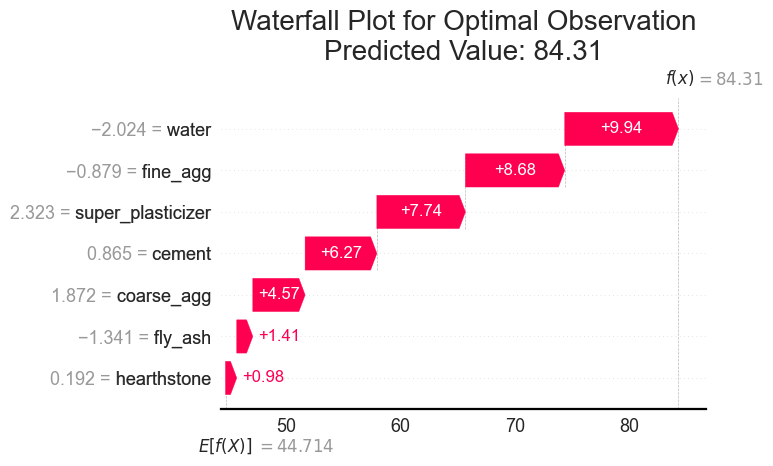

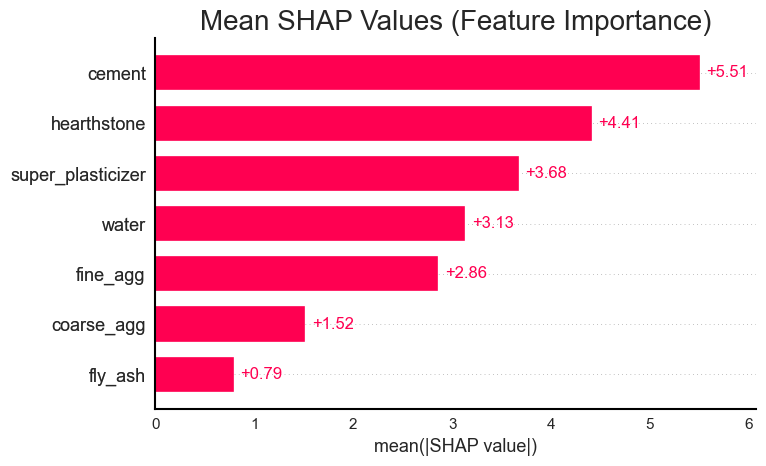

In [20]:
# SHAP analysis
best_model_name = max(results, key=lambda x: results[x]['Test R2'])
best_model = best_models[best_model_name]

print(f"\nBest Performing Model: {best_model_name}")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

# 2. Waterfall Plot (for observation with highest prediction)
best_idx = np.argmax(best_model.predict(X_test))
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap_values[best_idx], show=False)
plt.title(f'Waterfall Plot for Optimal Observation\nPredicted Value: {best_model.predict(X_test.iloc[[best_idx]])[0]:.2f}')
plt.tight_layout()
plt.show()

# 3. Bar Plot (mean SHAP values)
plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values, show=False)
plt.title('Mean SHAP Values (Feature Importance)')
plt.tight_layout()
plt.show()

In [24]:
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa

In [25]:
def create_taylor_diagram(ax, fig, refstd):
    """Set up Taylor diagram axes on polar plot"""
    tr = PolarAxes.PolarTransform()
    
    # Correlation labels
    rlocs = np.concatenate([np.arange(0.1, 0.9, 0.1),
                            np.arange(0.9, 1.0, 0.01)])
    tlocs = np.arccos(rlocs)
    gl1 = gf.FixedLocator(tlocs)
    tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
    
    # Standard deviation axis extent
    smin = 0
    smax = 1.6 * refstd
    
    ghelper = fa.GridHelperCurveLinear(
        tr,
        extremes=(0, np.pi/2, smin, smax),
        grid_locator1=gl1,
        tick_formatter1=tf1)
    
    ax = fa.FloatingSubplot(fig, 111, grid_helper=ghelper)
    fig.add_subplot(ax)
    
    # Adjust axes
    ax.axis["top"].set_axis_direction("bottom")
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")
    
    ax.axis["left"].set_axis_direction("bottom")
    ax.axis["left"].label.set_text("Standard deviation")
    
    ax.axis["right"].set_axis_direction("top")
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].label.set_text("Standard deviation")
    
    ax.axis["bottom"].set_visible(False)
    
    ax.grid(True)
    
    return ax


C:\Users\Zikesh PC\AppData\Local\Temp\ipykernel_10668\2160761873.py:3: MatplotlibDeprecationWarning: Passing `apply_theta_transforms=True` (the default) is deprecated since Matplotlib 3.9. Support for this will be removed in Matplotlib in 3.11. To prevent this warning, set `apply_theta_transforms=False`, and make sure to shift theta values before being passed to this transform.
  tr = PolarAxes.PolarTransform()


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

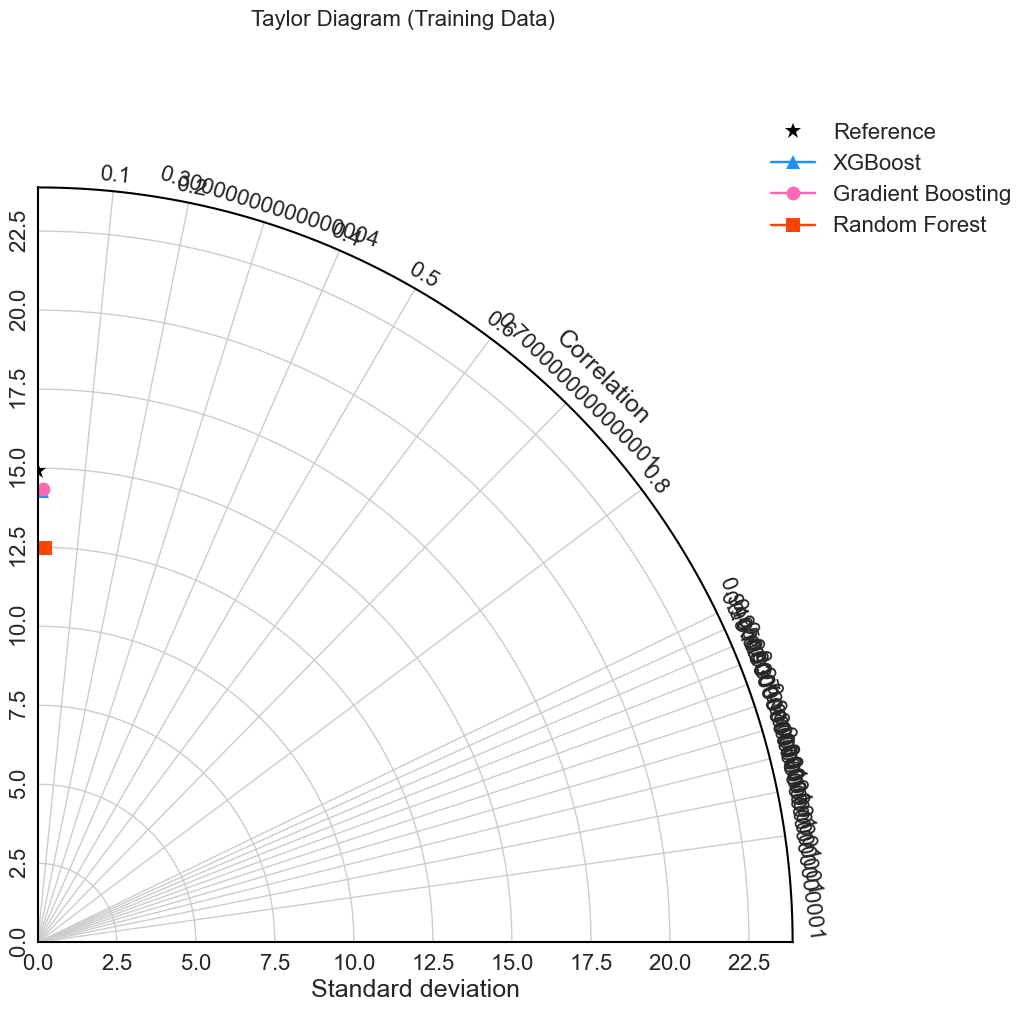

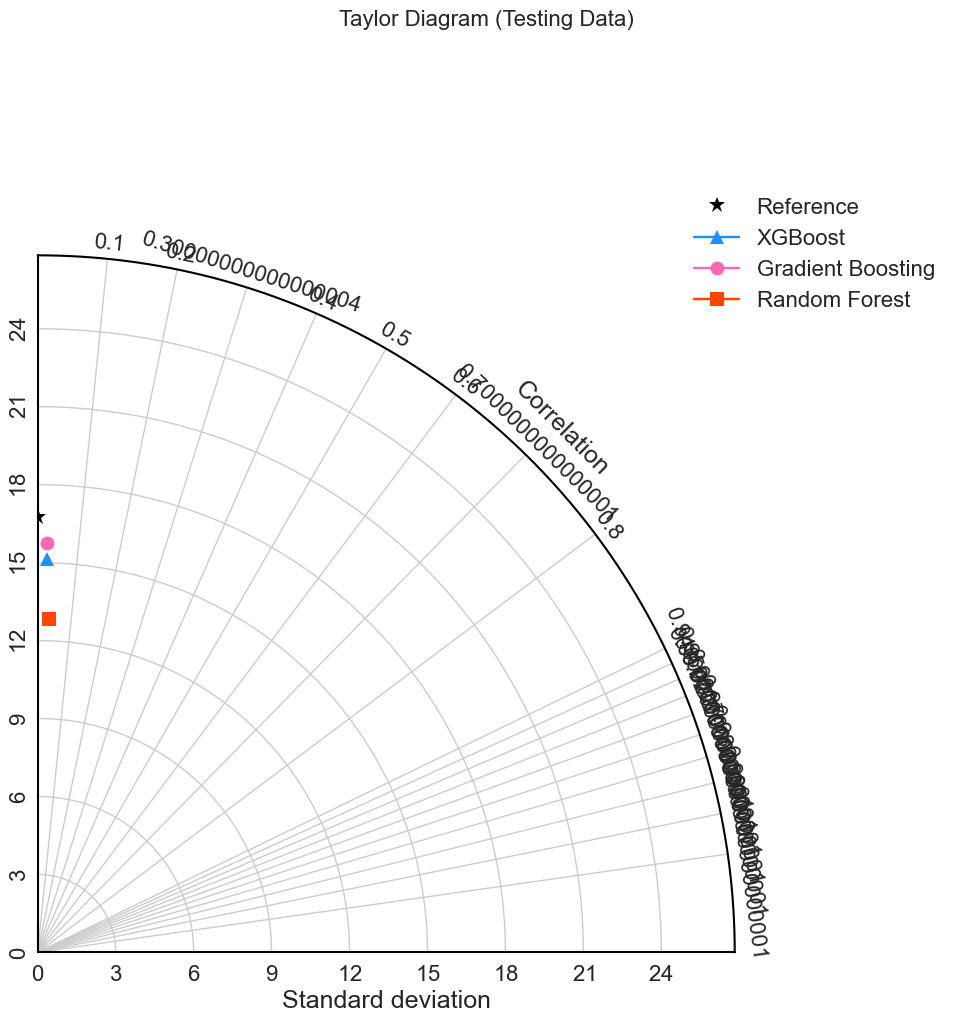

In [26]:
def plot_taylor_diagram(models, X_train, y_train, X_test, y_test):
    """Generate Taylor diagrams for training and testing data"""
    # Calculate reference statistics
    refstd_train = np.std(y_train)
    refstd_test = np.std(y_test)
    
    # Colors and markers for models
    colors = {
        'Gradient Boosting': '#FF69B4',  # Pink
        'Random Forest': '#FF4500',      # Red
        'XGBoost': '#1E90FF'             # Blue
    }
    
    markers = {
        'Gradient Boosting': 'o',
        'Random Forest': 's',
        'XGBoost': '^'
    }
    
    # Create figures
    fig_train = plt.figure(figsize=(10, 10))
    fig_test = plt.figure(figsize=(10, 10))
    
    # Create Taylor diagram axes
    ax_train = create_taylor_diagram(None, fig_train, refstd_train)
    ax_test = create_taylor_diagram(None, fig_test, refstd_test)
    
    # Plot reference point
    ax_train.plot(0, refstd_train, 'k*', ms=12, label='Reference')
    ax_test.plot(0, refstd_test, 'k*', ms=12, label='Reference')
    
    # Plot each model
    for name, model in models.items():
        # Training data
        y_pred_train = model.predict(X_train)
        std_train = np.std(y_pred_train)
        corr_train = np.corrcoef(y_train, y_pred_train)[0, 1]
        theta_train = np.arccos(corr_train)
        
        ax_train.plot(theta_train, std_train,
                     color=colors.get(name, '#666666'),
                     marker=markers.get(name, 'o'),
                     ms=10,
                     label=name)
        
        # Testing data
        y_pred_test = model.predict(X_test)
        std_test = np.std(y_pred_test)
        corr_test = np.corrcoef(y_test, y_pred_test)[0, 1]
        theta_test = np.arccos(corr_test)
        
        ax_test.plot(theta_test, std_test,
                    color=colors.get(name, '#666666'),
                    marker=markers.get(name, 'o'),
                    ms=10,
                    label=name)
    
    # Add legends and titles
    ax_train.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax_test.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    fig_train.suptitle('Taylor Diagram (Training Data)', y=1.05, fontsize=16)
    fig_test.suptitle('Taylor Diagram (Testing Data)', y=1.05, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Generate diagrams for your models
plot_taylor_diagram(best_models, X_train, y_train, X_test, y_test)